# Car Advert Price Prediction (Regression)

This notebook follows a standard machine learning pipeline: data understanding/EDA → cleaning & preprocessing → model building/tuning → evaluation & analysis.

**Reproducibility:** set a fixed random seed; keep `adverts.csv` in the same folder as this notebook.


In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# splitting and evaluation
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# preprocessing (removing missing values, scaling, encoding)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import FunctionTransformer

pd.set_option("display.float_format", "{:.0f}".format)
from sklearn.inspection import permutation_importance


In [3]:
# so randomness can be reproduced
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [4]:
adverts = pd.read_csv("adverts.csv")

In [5]:
# check data parsed correctly
adverts.head(5)

,public_reference,mileage,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type
0,202006039777689,0,NaN,Grey,Volvo,XC90,NEW,NaN,73970,SUV,False,Petrol Plug-in Hybrid
1,202007020778260,108230,61,Blue,Jaguar,XF,USED,2011,7000,Saloon,False,Diesel
2,202007020778474,7800,17,Grey,SKODA,Yeti,USED,2017,14000,SUV,False,Petrol
3,202007080986776,45000,16,Brown,Vauxhall,Mokka,USED,2016,7995,Hatchback,False,Diesel
4,202007161321269,64000,64,Grey,Land Rover,Range Rover Sport,USED,2015,26995,SUV,False,Diesel


In [6]:
adverts.shape

(402005, 12)

In [7]:
adverts.sample(5, random_state=RANDOM_STATE)

,public_reference,mileage,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type
332044,202010074692259,2826,69,Silver,Volkswagen,Sharan,USED,2019,23000,MPV,False,Diesel
173955,202009023198786,10601,19,Red,Nissan,Qashqai,USED,2019,16000,SUV,False,Petrol
367464,202007221569681,23000,58,Silver,Honda,Jazz,USED,2008,4799,Hatchback,False,Petrol
47695,202009113590641,9419,17,Silver,Volkswagen,Polo,USED,2017,11000,Hatchback,False,Petrol
210184,202010195186332,113250,16,Grey,Vauxhall,Insignia,USED,2016,5400,Hatchback,False,Diesel


In [8]:
# identify value types, and missing values
adverts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402005 entries, 0 to 402004
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   public_reference       402005 non-null  int64  
 1   mileage                401878 non-null  float64
 2   reg_code               370148 non-null  object 
 3   standard_colour        396627 non-null  object 
 4   standard_make          402005 non-null  object 
 5   standard_model         402005 non-null  object 
 6   vehicle_condition      402005 non-null  object 
 7   year_of_registration   368694 non-null  float64
 8   price                  402005 non-null  int64  
 9   body_type              401168 non-null  object 
 10  crossover_car_and_van  402005 non-null  bool   
 11  fuel_type              401404 non-null  object 
dtypes: bool(1), float64(2), int64(2), object(7)
memory usage: 34.1+ MB


In [9]:
adverts.describe().T

,count,mean,std,min,25%,50%,75%,max
public_reference,402005,202007077472444,16916615997,201307177852187,202009023197699,202009304400624,202010175124399,202011025683478
mileage,401878,37744,34832,0,10481,28630,56876,999999
year_of_registration,368694,2015,8,999,2013,2016,2018,2020
price,402005,17342,46437,120,7495,12600,20000,9999999


## 1. Data understanding & exploration

Quick checks: missingness, target distribution/skew, and simple relationships with key predictors.


In [10]:
# Missing values summary (counts and %)
missing = adverts.isna().mean().sort_values(ascending=False).to_frame("missing_frac")
missing["missing_count"] = adverts.isna().sum()
missing.head(15)


,missing_frac,missing_count
year_of_registration,0,33311
reg_code,0,31857
standard_colour,0,5378
body_type,0,837
fuel_type,0,601
mileage,0,127
public_reference,0,0
standard_make,0,0
vehicle_condition,0,0
standard_model,0,0


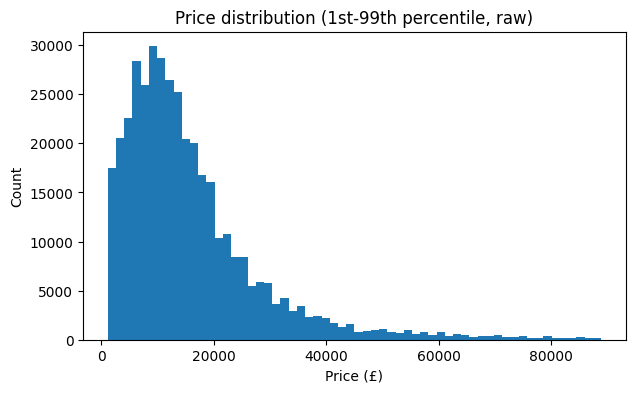

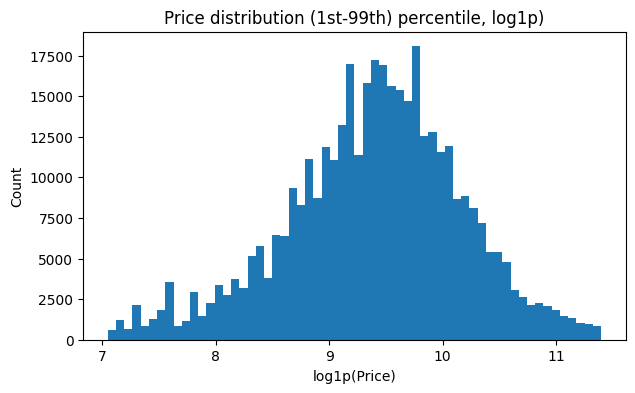

In [21]:
# Drop NaNs once
prices = adverts["price"].dropna()

lower_bound, upper_bound = 0.01, 0.99

# 25th and 75th percentiles (raw prices)
p01, p99 = prices.quantile([lower_bound, upper_bound])

plt.figure(figsize=(7,4))
plt.hist(prices, bins=60, range=(p01, p99))
plt.xlabel("Price (£)")
plt.ylabel("Count")
plt.title("Price distribution (1st-99th percentile, raw)")
plt.show()

# Log1p prices
log_prices = np.log1p(prices)
log_p01, log_p99 = log_prices.quantile([lower_bound, upper_bound])

plt.figure(figsize=(7,4))
plt.hist(log_prices, bins=60, range=(log_p01, log_p99))
plt.xlabel("log1p(Price)")
plt.ylabel("Count")
plt.title("Price distribution (1st-99th) percentile, log1p)")
plt.show()


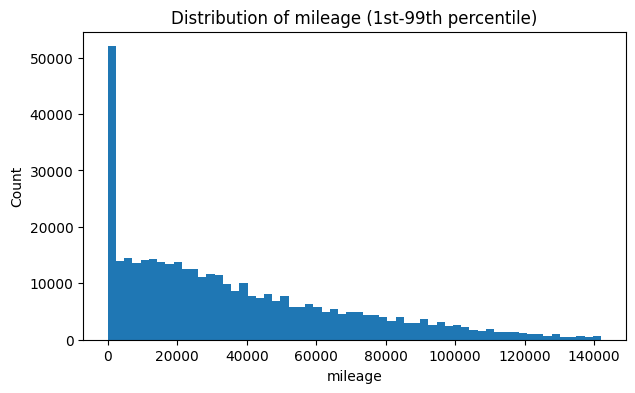

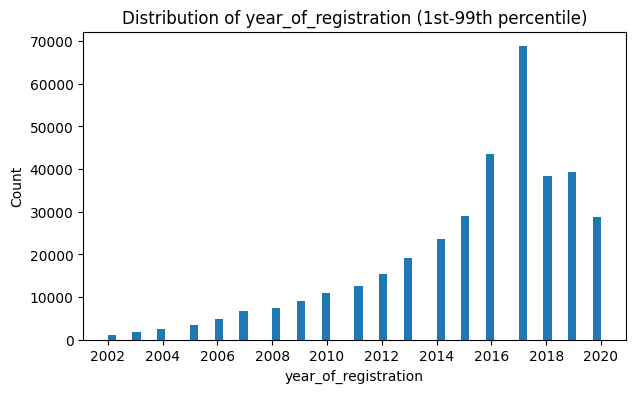

In [22]:
from matplotlib.ticker import MaxNLocator

# Numeric feature distributions (using predefined percentile bounds)
for col in ["mileage", "year_of_registration"]:
    if col in adverts.columns:
        data = adverts[col].dropna()

        # Use pre-defined percentile bounds
        p_low, p_high = data.quantile([lower_bound, upper_bound])

        plt.figure(figsize=(7,4))
        plt.hist(data, bins=60, range=(p_low, p_high))
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.title(
            f"Distribution of {col} (1st-99th percentile)")

        # Force integer ticks for year_of_registration
        if col == "year_of_registration":
            plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

        plt.show()


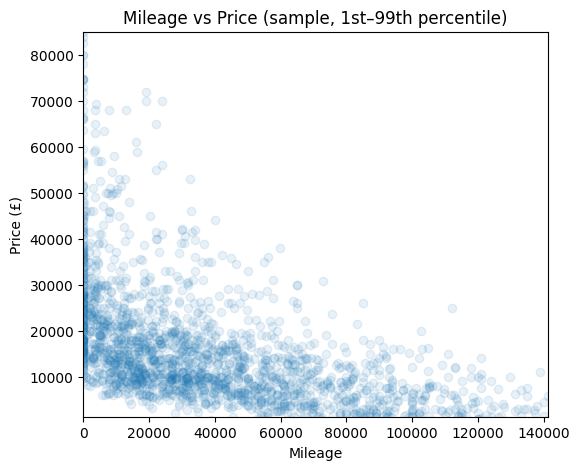

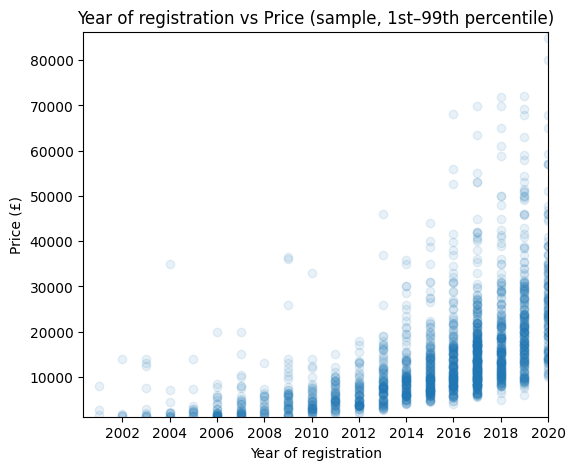

,median_price
standard_make,
Pagani,2400000
Bugatti,1495000
Lamborghini,174990
Ferrari,145000
McLaren,137972
Rolls-Royce,130000
Radical,125950
BAC,106450
AC,94950


,median_price
fuel_type,
Diesel Hybrid,39990
Diesel Plug-in Hybrid,35991
Petrol Plug-in Hybrid,30995
Electric,27894
Petrol Hybrid,17814
Bi Fuel,14000
Diesel,13495
Petrol,11000
Natural Gas,3795


,median_price
body_type,
Camper,30000
Minibus,19500
Coupe,18000
SUV,17950
Pickup,17376
Saloon,16250
Combi Van,15125
Convertible,14900
Limousine,13995


,median_price
vehicle_condition,
NEW,26760
USED,11890


In [ ]:
# Sample for better visuals
sample_vis = adverts.sample(2000, random_state=RANDOM_STATE)

# ---- Mileage vs Price ----
x_mileage = sample_vis["mileage"].dropna()
y_price = sample_vis.loc[x_mileage.index, "price"].dropna()

# Apply percentile bounds
x_low, x_high = x_mileage.quantile([lower_bound, upper_bound])
y_low, y_high = y_price.quantile([lower_bound, upper_bound])

plt.figure(figsize=(6,5))
plt.scatter(
    sample_vis.loc[x_mileage.index, "mileage"],
    sample_vis.loc[x_mileage.index, "price"],
    alpha=0.1
)
plt.xlim(x_low, x_high)
plt.ylim(y_low, y_high)
plt.xlabel("Mileage")
plt.ylabel("Price (£)")
plt.title("Mileage vs Price (sample, 1st–99th percentile)")
plt.show()

# ---- Year of registration vs Price ----
x_year = sample_vis["year_of_registration"].dropna()
y_price = sample_vis.loc[x_year.index, "price"].dropna()

# Apply percentile bounds
x_low, x_high = x_year.quantile([lower_bound, upper_bound])
y_low, y_high = y_price.quantile([lower_bound, upper_bound])

plt.figure(figsize=(6,5))
plt.scatter(
    sample_vis.loc[x_year.index, "year_of_registration"],
    sample_vis.loc[x_year.index, "price"],
    alpha=0.1
)
plt.xlim(x_low, x_high)
plt.ylim(y_low, y_high)
plt.xlabel("Year of registration")
plt.ylabel("Price (£)")
plt.title("Year of registration vs Price (sample, 1st–99th percentile)")

# Force integer ticks for year
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

# ---- Median price by key categorical predictors ----
for cat in ["standard_make", "fuel_type", "body_type", "vehicle_condition"]:
    if cat in adverts.columns:
        display(
            adverts
            .groupby(cat)["price"]
            .median()
            .sort_values(ascending=False)
            .head(15)
            .to_frame("median_price")
        )


## 2. Data processing (cleaning + preparation)


In [13]:
## 2. Data processing (cleaning + preparation)

# Target variable
target = "price"

# Remove non-predictive identifier column
cleaned_ads = adverts.drop(columns=["public_reference"]).copy()

# --- Basic sanity / noise handling (rule-based) ---
# Keep only positive prices
before = len(cleaned_ads)
cleaned_ads = cleaned_ads[cleaned_ads[target].notna() & (cleaned_ads[target] > 0)]
print(f"Removed {before - len(cleaned_ads):,} rows with missing/non-positive price.")

# Mileage should not be negative; clip extreme values for stability (keeps rows but limits leverage)
if "mileage" in cleaned_ads.columns:
    neg_mileage = (cleaned_ads["mileage"] < 0).sum(skipna=True)
    cleaned_ads = cleaned_ads[cleaned_ads["mileage"].isna() | (cleaned_ads["mileage"] >= 0)]
    cleaned_ads["mileage"] = cleaned_ads["mileage"].clip(0, 400_000)
    print(f"Removed {neg_mileage:,} rows with negative mileage. Clipped mileage to [0, 400000].")

# Registration year sanity range (keep NA; filter impossible years)
if "year_of_registration" in cleaned_ads.columns:
    before = len(cleaned_ads)
    cleaned_ads = cleaned_ads[
        cleaned_ads["year_of_registration"].isna() |
        cleaned_ads["year_of_registration"].between(1980, 2026)
    ]
    print(f"Removed {before - len(cleaned_ads):,} rows with implausible registration year.")

cleaned_ads.head(10)


Removed 0 rows with missing/non-positive price.
Removed 0 rows with negative mileage. Clipped mileage to [0, 400000].
Removed 331 rows with implausible registration year.


,mileage,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type
0,0,NaN,Grey,Volvo,XC90,NEW,NaN,73970,SUV,False,Petrol Plug-in Hybrid
1,108230,61,Blue,Jaguar,XF,USED,2011,7000,Saloon,False,Diesel
2,7800,17,Grey,SKODA,Yeti,USED,2017,14000,SUV,False,Petrol
3,45000,16,Brown,Vauxhall,Mokka,USED,2016,7995,Hatchback,False,Diesel
4,64000,64,Grey,Land Rover,Range Rover Sport,USED,2015,26995,SUV,False,Diesel
5,16000,17,Blue,Audi,S5,USED,2017,29000,Convertible,False,Petrol
6,24075,17,Red,Vauxhall,Viva,USED,2017,5861,Hatchback,False,Petrol
7,99000,13,Bronze,Land Rover,Range Rover,USED,2013,24475,SUV,False,Diesel
8,111236,08,Black,Mercedes-Benz,S Class,USED,2008,6995,Limousine,False,Diesel
9,9500,19,White,Land Rover,Range Rover,USED,2019,79995,SUV,False,Diesel


In [14]:
cleaned_ads.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401674 entries, 0 to 402004
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   mileage                401549 non-null  float64
 1   reg_code               369863 non-null  object 
 2   standard_colour        396330 non-null  object 
 3   standard_make          401674 non-null  object 
 4   standard_model         401674 non-null  object 
 5   vehicle_condition      401674 non-null  object 
 6   year_of_registration   368363 non-null  float64
 7   price                  401674 non-null  int64  
 8   body_type              400866 non-null  object 
 9   crossover_car_and_van  401674 non-null  bool   
 10  fuel_type              401096 non-null  object 
dtypes: bool(1), float64(2), int64(1), object(7)
memory usage: 34.1+ MB


In [15]:
cleaned_ads.describe().T

,count,mean,std,min,25%,50%,75%,max
mileage,401549,37724,34700,0,10473,28610,56833,400000
year_of_registration,368363,2015,4,1980,2013,2016,2018,2020
price,401674,17289,46202,120,7495,12600,20000,9999999


In [16]:
X, y = cleaned_ads.drop(columns=[target]), cleaned_ads[target]

In [18]:
# segmenting features into their type
numeric_features = [
    "mileage",
    "year_of_registration"
]

categorical_features = [
    "reg_code",
    "standard_colour",
    "standard_make",
    "standard_model",
    "vehicle_condition",
    "body_type",
    "fuel_type"
]

boolean_features = [
    "crossover_car_and_van"
]

# double checking
print(f"Numeric: {numeric_features}")
print(f"Categorical: {categorical_features}")
print(f"Boolean: {boolean_features}")

Numeric: ['mileage', 'year_of_registration']
Categorical: ['reg_code', 'standard_colour', 'standard_make', 'standard_model', 'vehicle_condition', 'body_type', 'fuel_type']
Boolean: ['crossover_car_and_van']


In [19]:
# dealing with missing values

# replace missing numeric values with median, and scale for Nearest Neighbour and Linear Regression models.
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# replace missing categorical cells with unknown
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# pass bool features as is because there are no missing values
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("bool", "passthrough", boolean_features),
    ],
    remainder="drop"
)

In [20]:
# checking that transformer is configured correctly
_ = preprocess.fit_transform(X.sample(1000, random_state=RANDOM_STATE))

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size=0.2, random_state=RANDOM_STATE
)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(321339, 10) (80335, 10)
(321339,) (80335,)


In [22]:
# linear regression model
linreg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

linreg.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers

In [23]:
y_pred = linreg.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:,.0f}")
print(f"RMSE: {rmse:,.0f}")
print(f"R^2:  {r2:.3f}")

MAE:  3,695
RMSE: 36,977
R^2:  0.329


In [24]:
# log transforming price to deal with skewed pricing (new cars, luxury, etc.)
y_log = np.log1p(y)

X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=RANDOM_STATE
)

# reducing the dataset due to high memory usage in KNN model
X_train_sub = X_train.sample(50000, random_state=RANDOM_STATE)
y_train_sub = y_train_log.loc[X_train_sub.index]

linreg_log = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

linreg_log.fit(X_train, y_train_log)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers

In [25]:
y_pred_log = linreg_log.predict(X_test)

# transforming price to actual values
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test_log)

In [26]:
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"MAE (log model):  {mae:,.0f}")
print(f"RMSE (log model): {rmse:,.0f}")
print(f"R^2 (log model):  {r2:.3f}")

MAE (log model):  2,474
RMSE (log model): 36,942
R^2 (log model):  0.330


In [ ]:
# K-Nearest-Neighbour

# using the same data - same imputations, encoding, and scaling.
knn = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", KNeighborsRegressor())
])

param_grid_knn = {
    "model__n_neighbors": [5, 7, 9],
    "model__weights": ["uniform", "distance"] # 6 permutations
}


In [28]:
cv = KFold(n_splits=5, shuffle=True, random_state = RANDOM_STATE)

In [30]:
grid_knn = GridSearchCV(
    knn,
    param_grid_knn,
    scoring="neg_mean_absolute_error",
    cv=cv,
    n_jobs=5
)

grid_knn.fit(X_train_sub, y_train_sub)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...Regressor())])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'model__n_neighbors': [5, 7, ...], 'model__weights': ['uniform', 'distance']}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'neg_mean_absolute_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",5
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",KFold(n_split... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and param

In [31]:
best_knn = grid_knn.best_estimator_
print("Best KNN params:", grid_knn.best_params_)
print(f"Best CV MAE (log-scale): {-grid_knn.best_score_:,.4f}")


y_pred_log_knn = best_knn.predict(X_test)

y_pred_knn = np.expm1(y_pred_log_knn)
y_true = np.expm1(y_test_log)

mae_knn = mean_absolute_error(y_true, y_pred_knn)
rmse_knn = np.sqrt(mean_squared_error(y_true, y_pred_knn))
r2_knn = r2_score(y_true, y_pred_knn)

print(f"KNN MAE:  {mae_knn:,.0f}")
print(f"KNN RMSE: {rmse_knn:,.0f}")
print(f"KNN R^2:  {r2_knn:.3f}")


Best KNN params: {'model__n_neighbors': 7, 'model__weights': 'distance'}
Best CV MAE (log-scale): 0.1631
KNN MAE:  3,041
KNN RMSE: 41,572
KNN R^2:  0.151


In [37]:
# Decision Tree Regressor (tuned)

tree = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", DecisionTreeRegressor(random_state=RANDOM_STATE))
])

# A small-but-realistic grid to explore under/overfitting trade-offs
param_grid_tree = {
    "model__max_depth": [5, 10, 20],
    "model__min_samples_leaf": [1, 10, 20],
    "model__min_samples_split": [2, 10] # 18 permutations
}

# Use the same reproducible CV strategy as other models
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)


In [39]:
grid_tree = GridSearchCV(
    tree,
    param_grid_tree,
    scoring="neg_mean_absolute_error",
    cv=cv,
    n_jobs=20 # speeds up fitting, arbitrary number chosen based on PC specs
)

grid_tree.fit(X_train, y_train_log)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'model__max_depth': [5, 10, ...], 'model__min_samples_leaf': [1, 10, ...], 'model__min_samples_split': [2, 10]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'neg_mean_absolute_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",20
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",KFold(n_split... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the compu

In [40]:
best_tree = grid_tree.best_estimator_
print("Best Decision Tree params:", grid_tree.best_params_)
print(f"Best CV MAE (log-scale): {-grid_tree.best_score_:,.4f}")

# Predict on test and invert log-transform for evaluation on original £ scale
y_pred_log_tree = best_tree.predict(X_test)
y_pred_tree = np.expm1(y_pred_log_tree)

y_true = np.expm1(y_test_log)

mae_tree = mean_absolute_error(y_true, y_pred_tree)
rmse_tree = np.sqrt(mean_squared_error(y_true, y_pred_tree))
r2_tree = r2_score(y_true, y_pred_tree)

print(f"Tree MAE:  {mae_tree:,.0f}")
print(f"Tree RMSE: {rmse_tree:,.0f}")
print(f"Tree R^2:  {r2_tree:.3f}")


Best Decision Tree params: {'model__max_depth': 20, 'model__min_samples_leaf': 10, 'model__min_samples_split': 2}
Best CV MAE (log-scale): 0.1818
Tree MAE:  3,198
Tree RMSE: 40,934
Tree R^2:  0.177


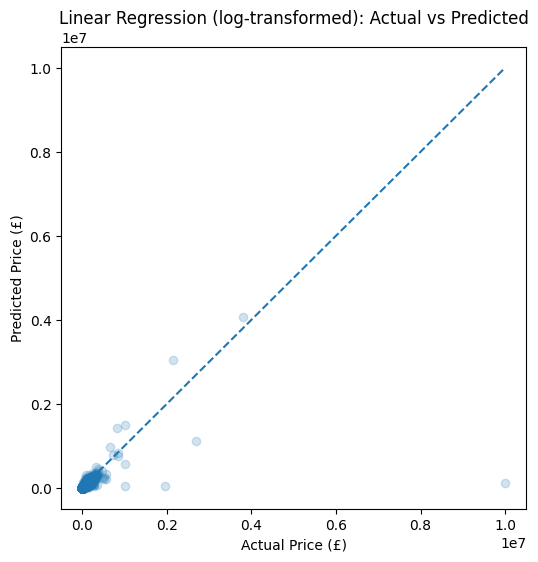

In [41]:
# visualisation

plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.2)
plt.plot([y_true.min(), y_true.max()],
        [y_true.min(),y_true.max()],
        linestyle="--"
        )
plt.xlabel("Actual Price (£)")
plt.ylabel("Predicted Price (£)")
plt.title("Linear Regression (log-transformed): Actual vs Predicted")
plt.show()

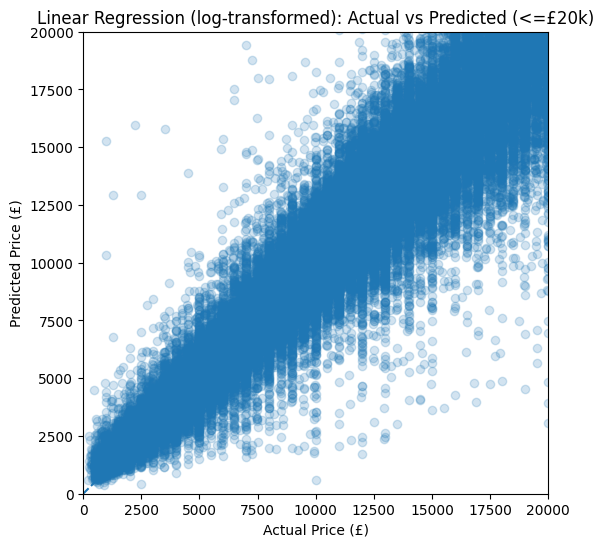

In [42]:
# outlier prices condense points in the graph, making it more difficult to see
max_price = 20000

plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.2)
plt.plot([0, max_price], [0,max_price], linestyle="--")

plt.xlim(0,max_price)
plt.ylim(0,max_price)

plt.xlabel("Actual Price (£)")
plt.ylabel("Predicted Price (£)")
plt.title("Linear Regression (log-transformed): Actual vs Predicted (<=£20k)")
plt.show()

In [43]:
vis_idx = np.random.choice(len(y_true), size=1000, replace=False)

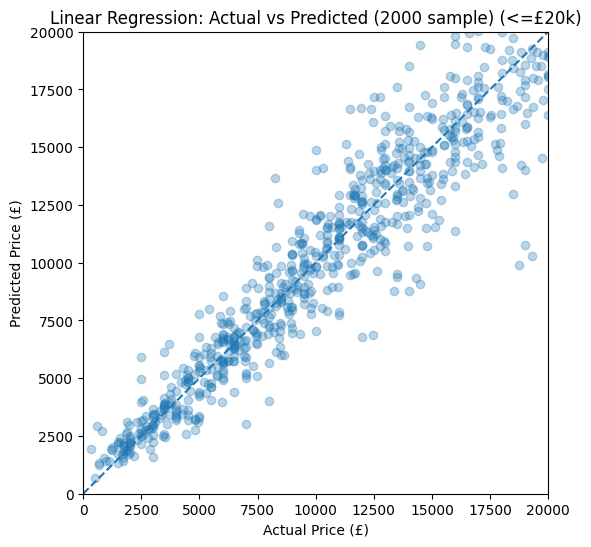

In [44]:
# reducing sample size to 2000 entries to better see trends

plt.figure(figsize=(6,6))
plt.scatter(y_true.iloc[vis_idx], y_pred[vis_idx], alpha=0.3)
plt.plot([0, max_price], [0, max_price], linestyle="--")

plt.xlim(0, max_price)
plt.ylim(0, max_price)

plt.xlabel("Actual Price (£)")
plt.ylabel("Predicted Price (£)")
plt.title("Linear Regression: Actual vs Predicted (2000 sample) (<=£20k)")
plt.show()

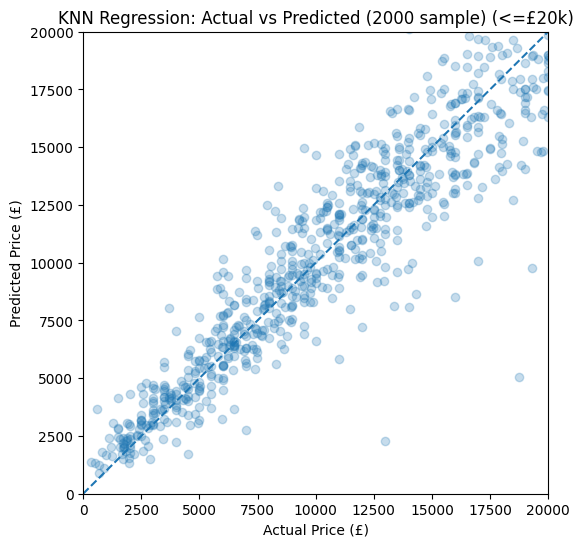

In [45]:
# visualisation of Nearest Neighbour model

plt.figure(figsize=(6,6))
plt.scatter(y_true.iloc[vis_idx], y_pred_knn[vis_idx], alpha=0.25)
plt.plot([0, max_price], [0, max_price], linestyle="--")

plt.xlim(0, max_price)
plt.ylim(0, max_price)

plt.xlabel("Actual Price (£)")
plt.ylabel("Predicted Price (£)")
plt.title("KNN Regression: Actual vs Predicted (2000 sample) (<=£20k)")
plt.show()

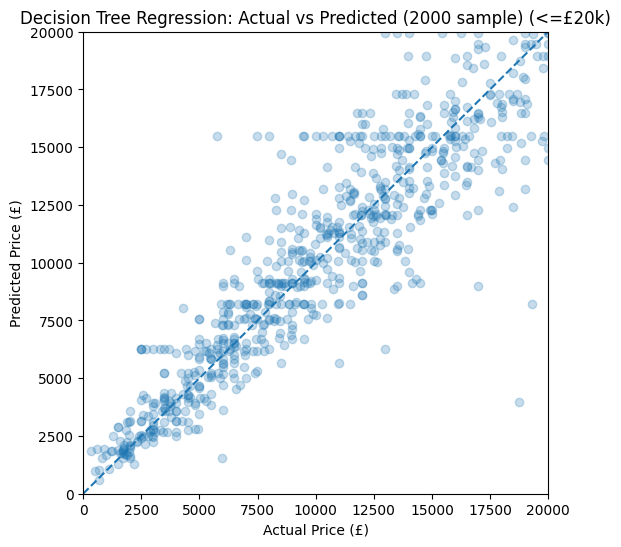

In [46]:
# visualisation of Decision Tree Regressor

plt.figure(figsize=(6,6))
plt.scatter(y_true.iloc[vis_idx], y_pred_tree[vis_idx], alpha=0.25)
plt.plot([0, max_price], [0, max_price], linestyle="--")

plt.xlim(0, max_price)
plt.ylim(0, max_price)

plt.xlabel("Actual Price (£)")
plt.ylabel("Predicted Price (£)")
plt.title("Decision Tree Regression: Actual vs Predicted (2000 sample) (<=£20k)")
plt.show()

## 4. Model evaluation & analysis

Compare models on the held-out test set, inspect residuals for the selected model, and use permutation importance to understand which inputs matter most.


In [47]:
# --- Model comparison on the test set (original £ scale) ---

# Linear regression (log-target)
y_pred_lin = np.expm1(linreg_log.predict(X_test))

# KNN (log-target)
y_pred_knn2 = np.expm1(best_knn.predict(X_test))

# Decision tree (log-target)
y_pred_tree2 = np.expm1(best_tree.predict(X_test))

y_true_price = np.expm1(y_test_log)

def metrics(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred),
    }

results = pd.DataFrame({
    "LinearRegression_log": metrics(y_true_price, y_pred_lin),
    "KNN_log": metrics(y_true_price, y_pred_knn2),
    "DecisionTree_log": metrics(y_true_price, y_pred_tree2),
}).T.sort_values("MAE")

results


,MAE,RMSE,R2
LinearRegression_log,2474,36942,0
KNN_log,3041,41572,0
DecisionTree_log,3198,40934,0


Selected model: LinearRegression_log


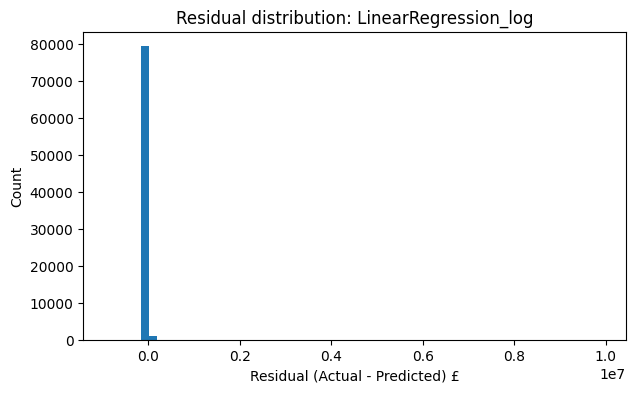

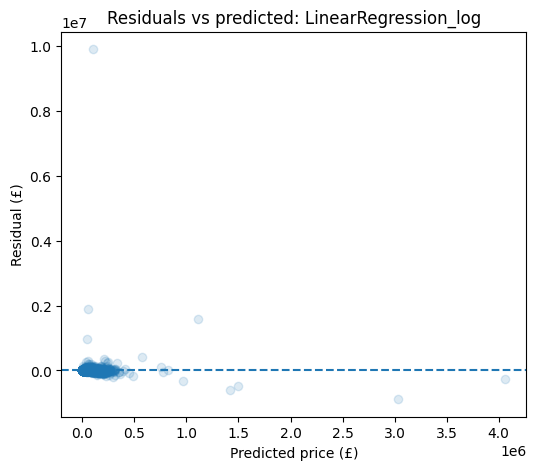

In [48]:
# Pick the best model by MAE on the test set
best_name = results.index[0]
print("Selected model:", best_name)

if best_name == "LinearRegression_log":
    best_model = linreg_log
    y_pred_best = y_pred_lin
elif best_name == "KNN_log":
    best_model = best_knn
    y_pred_best = y_pred_knn2
else:
    best_model = best_tree
    y_pred_best = y_pred_tree2

residuals = y_true_price - y_pred_best

plt.figure(figsize=(7,4))
plt.hist(residuals, bins=60)
plt.xlabel("Residual (Actual - Predicted) £")
plt.ylabel("Count")
plt.title(f"Residual distribution: {best_name}")
plt.show()

plt.figure(figsize=(6,5))
plt.scatter(y_pred_best, residuals, alpha=0.15)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted price (£)")
plt.ylabel("Residual (£)")
plt.title(f"Residuals vs predicted: {best_name}")
plt.show()
